In [1]:
# default_exp load_videos

# load_videos

> This module loads video data and surf / weather reports abd saves them to disk.

In [2]:
#hide
import nbdev.showdoc as showdoc

This repo contains some examples of how to use Surfline's wave API:
https://github.com/swrobel/meta-surf-forecast#new-api-v2

In [3]:
#export
import requests
def get_surfdata(spotid):
    """Retrieves current and forecast surf conditions for the next 24 hours from Surfline. 
       Wave data interval is 6 hours from 12 AM, wind and weather interval is 2 hours """
    payload = {"spotId":spotid, "days":"2", "intervalHours":"6"}
    wave_data = requests.get("https://services.surfline.com/kbyg/spots/forecasts/wave", params=payload).json()
    payload["intervalHours"] = "2"
    wind_data = requests.get("https://services.surfline.com/kbyg/spots/forecasts/wind", params=payload).json() 
    tides_data = requests.get("https://services.surfline.com/kbyg/spots/forecasts/tides", params=payload).json()
    weather_data = requests.get("https://services.surfline.com/kbyg/spots/forecasts/weather", params=payload).json()
    
    surf_data = wave_data
    surf_data['associated']['spotId'] = spotid
    surf_data['data']['wind'] = wind_data['data']['wind']
    surf_data['associated']['tideLocation'] = tides_data['associated']['tideLocation']
    surf_data['data']['tides'] = tides_data['data']['tides']
    surf_data['data']['weather'] = weather_data['data']['weather']
    
    return surf_data

The below data is the same as displayed on the Surfline website here:

https://www.surfline.com/surf-report/shirahama/584204204e65fad6a77098c4

In [4]:
surf_data = get_surfdata("584204204e65fad6a77098c4")
surf_data

{'associated': {'units': {'temperature': 'C',
   'tideHeight': 'M',
   'waveHeight': 'M',
   'windSpeed': 'KPH'},
  'utcOffset': 9,
  'location': {'lon': 138.973403, 'lat': 34.687813},
  'forecastLocation': {'lon': 138.982, 'lat': 34.689},
  'offshoreLocation': {'lon': 139, 'lat': 34},
  'spotId': '584204204e65fad6a77098c4',
  'tideLocation': {'name': 'Simoda, Sizuoka, Japan',
   'min': -0.09,
   'max': 1.75,
   'lon': 138.95,
   'lat': 34.6667,
   'mean': 1.01}},
 'data': {'wave': [{'timestamp': 1591282800,
    'surf': {'min': 0.08, 'max': 0.37, 'optimalScore': 2},
    'swells': [{'height': 0.79,
      'period': 7,
      'direction': 216.56,
      'directionMin': 207.42,
      'optimalScore': 0},
     {'height': 0.15,
      'period': 11,
      'direction': 53.44,
      'directionMin': 49.22,
      'optimalScore': 0},
     {'height': 0.43,
      'period': 7,
      'direction': 105.47,
      'directionMin': 97.73,
      'optimalScore': 0},
     {'height': 0.21,
      'period': 10,
     

In [5]:
assert set(['wave', 'wind', 'tides', 'weather']) == set(surf_data['data'].keys())
for datatype in surf_data['data'].keys():
    assert len(surf_data['data'][datatype]) > 4
    
import json
assert len(json.dumps(surf_data)) > 1000

In [6]:
#export
SURF_SPOTS = {"shirahama": {"cam_url": "https://www.youtube.com/watch?v=E6x_nn7k-Lc",
                            "spotid": "584204204e65fad6a77098c4"},
              "shinmaiko": {"cam_url": "https://www.youtube.com/watch?v=3dkBkAjNay4",  # A link to map location is on this page
                            "spotid": "584204204e65fad6a77097f3"} # This is actually for Isonoura, but closest available
                                                                  # Actual waves will be much smaller than reported here...
             }

# Surf cam video download

Initially tried downloading surf cam live-streams with youtube-dl, but switched to avoid some issues on linux.  

Streamlink also has better support for downloading only a portion of streams.

## "Shirahama Ohama Beach" 白浜大浜海水浴場（静岡県下田市）
!youtube-dl -f "bestvideo[height<=?1080]+bestaudio/best" -o "tmp.mp4" https://www.youtube.com/watch?v=WbRbWJZ7ZH0

(This video URL seems to update rather often...)

## 新舞子海水浴場 福ヶ浜 ライブ配信
!youtube-dl -f "bestvideo[height<=?1080]+bestaudio/best" -o "tmp.mp4" https://www.youtube.com/watch?v=3dkBkAjNay4

In [7]:
#export
import time
import os
import subprocess
from datetime import date
import json
    
def save_forecast_and_stream(surf_spot="shirahama", folder="data", duration_s=120, capture_output=False):
    
    # Get the surf data and save it to a descriptively named file
    surf_data = get_surfdata(SURF_SPOTS[surf_spot]["spotid"])

    # Extract values used in the filename
    # Wave data interval is 6 hours from 12 AM, wind and weather interval is 3 hours 
    max_surf_6am_cm = int(surf_data['data']['wave'][1]['surf']['max']*100)
    
    unix_time = int(time.time())
    descriptive_name = f"{surf_spot}_{unix_time}_SURF-{max_surf_6am_cm}cm"
    wave_data_filepath = os.path.join(folder, descriptive_name + '.json')

    with open(wave_data_filepath, 'w') as file:
        json.dump(surf_data, file, indent=4)

    # Then download the surf cam footage and save in a descriptively named file
    video_filepath = os.path.join(folder, descriptive_name + '.ts')    
    video_url  = SURF_SPOTS[surf_spot]['cam_url']
    # Using the cmd_string with shell=True is insecure.  
    # cmd_string = f'streamlink --force --hls-duration {duration_s} -o {video_filename} {video_url} 1080p,best'
    # String conversion to list done via `import shlex; shlex.split(cmd_string)`
    cmd_list = ['streamlink','--force','--hls-duration', str(int(duration_s)), '-o', video_filepath, video_url, '1080p,best']
    
    if capture_output:
        stdout=subprocess.PIPE # stdout=PIPE same as capture_output=True
    else:
        stdout = None
            
    proc = subprocess.run(args=cmd_list, timeout=duration_s+60, stdout=stdout)  
    

    return {"video_filepath": video_filepath,
            "video_subprocess": proc,
            "surf_data": surf_data}
    
    

## Basic tests
Download surf data and video file, then check their size and delete them.

In [8]:
results = save_forecast_and_stream(surf_spot='shirahama', folder='data', duration_s=10, capture_output=True)
sd = results['surf_data']
assert len(sd['data']['wave']) > 4
assert sd['data']['wave'][1]['surf']['max'] >= 0

vp = results['video_subprocess']
assert vp.returncode == 0
print(vp.stdout.decode())

vf = results['video_filepath']
video_filesize_bytes = os.path.getsize(vf)
assert video_filesize_bytes > 2e5 #(Even a ~10s video Should be larger than 200kb)

os.remove(vf)
os.remove(vf.strip('.ts') + '.json')

[cli][info] Found matching plugin youtube for URL https://www.youtube.com/watch?v=E6x_nn7k-Lc
[cli][info] Available streams: 144p (worst), 240p, 360p, 480p, 720p, 1080p (best)
[cli][info] Opening stream: 1080p (hls)
[stream.hls][info] Stopping stream early after 10
[cli][info] Stream ended
[cli][info] Closing currently open stream...



## Functions to load video frames using CV2

In [9]:
#export
import cv2

def decode_frame_sequence(stream_filepath, duration_s=10, start_s=0, RGB=False, one_image_per_n_frames=2):
    cap = cv2.VideoCapture(stream_filepath)
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count < 1:
        print("No frames in the video file")
        return None
    file_duration_s = frame_count/video_fps
    wait_ms = int(1000/video_fps)
    print(f'Decoding {stream_filepath}  Duration: {file_duration_s/60:0.1f}m ({(file_duration_s):0.2f}s)  FPS: {video_fps}')
    print(f'(outputting one image for every {one_image_per_n_frames} video frames)')
    n_frames = duration_s*int(video_fps)
    start_frame_index = int(start_s*int(video_fps))
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_index);
    frames = []
    
    for i in range(n_frames):
        # cache several frames
        ret, frame = cap.read()
        if i % one_image_per_n_frames != 0:
            continue
        if not ret:
            print("Reached end of video file, length may be shorter than expected.")
            break
        else:
            if RGB:
                frames.append(frame[:,:,::-1]) # BGR 2 RGB
            else:
                frames.append(frame) # BGR
    return frames
    

Decoding ./data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0
(outputting one image for every 2 video frames)


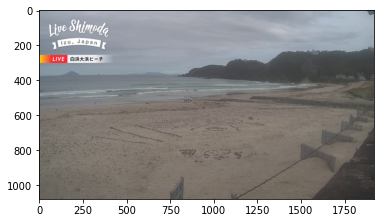

In [10]:
from matplotlib import pyplot as plt

frames = decode_frame_sequence('./data/shirahama_1590387334_SURF-93cm.ts', duration_s=2, start_s=100, RGB=True)

im = frames[0]
plt.imshow(im)

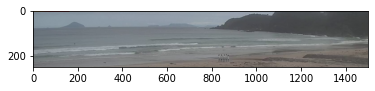

In [11]:
im = frames[0][300:550,0:1500,:]
plt.imshow(im)

In [15]:
import nbdev.export as export
export.notebook2script()

Converted 00_load_videos.ipynb.
Converted 01_wave_modeling.ipynb.
Converted 03_wave_detection.ipynb.
Converted index.ipynb.
